<p><font size="6"><b> CASE - Bacterial resistance experiment</b></font></p>


> *DS Data manipulation, analysis and visualisation in Python*  
> *December, 2019*

> *© 2017, Joris Van den Bossche and Stijn Van Hoey  (<mailto:jorisvandenbossche@gmail.com>, <mailto:stijnvanhoey@gmail.com>). Licensed under [CC BY 4.0 Creative Commons](http://creativecommons.org/licenses/by/4.0/)*

---

In this case study, we will make use of the open data, affiliated to the following [journal article](http://rsbl.royalsocietypublishing.org/content/12/5/20160064):

>Arias-Sánchez FI, Hall A (2016) Effects of antibiotic resistance alleles on bacterial evolutionary responses to viral parasites. Biology Letters 12(5): 20160064. https://doi.org/10.1098/rsbl.2016.0064



<img src="../img/bacteriophage.jpeg">

Check the full paper on the [web version](http://rsbl.royalsocietypublishing.org/content/12/5/20160064). The study handles:
> Antibiotic resistance has wide-ranging effects on bacterial phenotypes and evolution. However, the influence of antibiotic resistance on bacterial responses to parasitic viruses remains unclear, despite the ubiquity of such viruses in nature and current interest in therapeutic applications. We experimentally investigated this by exposing various Escherichia coli genotypes, including eight antibiotic-resistant genotypes and a mutator, to different viruses (lytic bacteriophages). Across 960 populations, we measured changes in population density and sensitivity to viruses, and tested whether variation among bacterial genotypes was explained by their relative growth in the absence of parasites, or mutation rate towards phage resistance measured by fluctuation tests for each phage

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import plotnine as p9

## Reading and processing the data

The data is available on [Dryad](http://www.datadryad.org/resource/doi:10.5061/dryad.90qb7.3), a general purpose data repository providing all kinds of data sets linked to journal papers. The downloaded data is available in this repository in the `data` folder as an excel-file called `Dryad_Arias_Hall_v3.xlsx`.

For the exercises, two sheets of the excel file will be used: 
* `Main experiment`: 


| Variable name | Description |
|---------------:|:-------------|
|**AB_r** |	Antibotic resistance |
|**Bacterial_genotype** | Bacterial genotype |
|**Phage_t** |	Phage treatment |
|**OD_0h** |	Optical density at the start of the experiment (0h) |
|**OD_20h**	| Optical density after 20h |
|**OD_72h**	| Optical density at the end of the experiment (72h) |
|**Survival_72h** |	Population survival at 72h (1=survived, 0=extinct) |
|**PhageR_72h**	| Bacterial sensitivity to the phage they were exposed to (0=no bacterial growth, 1= colony formation in the presence of phage) |

* `Falcor`: we focus on a subset of the columns:

| Variable name | Description |
|---------------:|:-------------|
| **Phage**  | Bacteriophage used in the fluctuation test (T4, T7 and lambda) |
| **Bacterial_genotype** | Bacterial genotype. |
| **log10 Mc** |	Log 10 of corrected mutation rate |
| **log10 UBc** |	Log 10 of corrected upper bound |
| **log10 LBc** |	Log 10 of corrected lower bound |

Reading the `main experiment` data set from the corresponding sheet:

In [38]:
main_experiment = pd.read_excel("../data/Dryad_Arias_Hall_v3.xlsx", sheet_name="Main experiment")
main_experiment

,AB_r,Bacterial_genotype,Phage_t,OD_0h,OD_20h,OD_72h,Survival_72h,PhageR_72h
0,Rif,D516G,C_noPhage,0.1971,0.5960,0.6900,1,NaN
1,Rif,D516G,C_noPhage,0.1593,0.5702,0.6989,1,NaN
2,Rif,D516G,C_noPhage,0.0926,0.6613,0.6474,1,NaN
3,Rif,D516G,C_noPhage,0.1482,0.6465,0.7045,1,NaN
4,Rif,D516G,C_noPhage,0.0978,0.6752,0.6700,1,NaN
...,...,...,...,...,...,...,...,...
949,sensitive,MUT,T7,0.0417,0.0402,0.3179,1,1.0
950,sensitive,MUT,T7,0.0789,0.0276,0.3601,1,1.0
951,sensitive,MUT,T7,0.0875,0.0216,0.3709,1,1.0
952,sensitive,MUT,T7,0.0755,0.0418,0.3628,1,1.0


Read the `Falcor` data and subset the columns of interest:

In [39]:
falcor = pd.read_excel("../data/Dryad_Arias_Hall_v3.xlsx", sheet_name="Falcor", 
                       skiprows=1)
falcor = falcor[["Phage", "Bacterial_genotype", "log10 Mc", "log10 UBc", "log10 LBc"]]
falcor.head()

,Phage,Bacterial_genotype,log10 Mc,log10 UBc,log10 LBc
0,T7,RP4,-6.908090,-6.766699,-7.086027
1,T7,RSF1010,-6.839080,-6.709209,-6.999176
2,T7,K43N,-7.072899,-6.933264,-7.248105
3,T7,S512F,-7.058820,-6.902430,-7.261299
4,T7,D516G,-6.920474,-6.722230,-7.199283


## Tidy the `main_experiment` data

*(If you're wondering what `tidy` data representations are, check again the `visualization_02_plotnine.ipynb` notebook)*

Actually, the columns `OD_0h`, `OD_20h` and `OD_72h` are representing the same variable (i.e. `optical_density`) and the column names itself represent a variable, i.e. `experiment_time_h`. Hence, it is stored in the table as *short* format and we could *tidy* these columns by converting them to 2 columns: `experiment_time_h` and `optical_density`.

Before making any changes to the data, we will add an identifier column for each of the current rows to make sure we keep the connection in between the entries of a row when converting from wide to ong format.

In [40]:
main_experiment["experiment_ID"] = ["ID_" + str(idx) for idx in range(len(main_experiment))]
main_experiment

,AB_r,Bacterial_genotype,Phage_t,OD_0h,OD_20h,OD_72h,Survival_72h,PhageR_72h,experiment_ID
0,Rif,D516G,C_noPhage,0.1971,0.5960,0.6900,1,NaN,ID_0
1,Rif,D516G,C_noPhage,0.1593,0.5702,0.6989,1,NaN,ID_1
2,Rif,D516G,C_noPhage,0.0926,0.6613,0.6474,1,NaN,ID_2
3,Rif,D516G,C_noPhage,0.1482,0.6465,0.7045,1,NaN,ID_3
4,Rif,D516G,C_noPhage,0.0978,0.6752,0.6700,1,NaN,ID_4
...,...,...,...,...,...,...,...,...,...
949,sensitive,MUT,T7,0.0417,0.0402,0.3179,1,1.0,ID_949
950,sensitive,MUT,T7,0.0789,0.0276,0.3601,1,1.0,ID_950
951,sensitive,MUT,T7,0.0875,0.0216,0.3709,1,1.0,ID_951
952,sensitive,MUT,T7,0.0755,0.0418,0.3628,1,1.0,ID_952


<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>Convert the columns `OD_0h`, `OD_20h` and `OD_72h` to a long format with the values stored in a column `optical_density` and the time in the experiment as `experiment_time_h`. Save the variable as <code>tidy_experiment</code></li>

</ul>

__Tip__: Have a look at `pandas_07_reshaping_data.ipynb` to find out the required function
    
</div>

In [42]:
tidy_experiment = main_experiment.melt(id_vars=['AB_r', 'Bacterial_genotype', 'Phage_t', 
                                                'Survival_72h', 'PhageR_72h', 'experiment_ID'], 
                                       value_vars=['OD_0h', 'OD_20h', 'OD_72h'], 
                                       var_name='experiment_time_h', 
                                       value_name='optical_density', )
tidy_experiment

,AB_r,Bacterial_genotype,Phage_t,Survival_72h,PhageR_72h,experiment_ID,experiment_time_h,optical_density
0,Rif,D516G,C_noPhage,1,NaN,ID_0,OD_0h,0.1971
1,Rif,D516G,C_noPhage,1,NaN,ID_1,OD_0h,0.1593
2,Rif,D516G,C_noPhage,1,NaN,ID_2,OD_0h,0.0926
3,Rif,D516G,C_noPhage,1,NaN,ID_3,OD_0h,0.1482
4,Rif,D516G,C_noPhage,1,NaN,ID_4,OD_0h,0.0978
...,...,...,...,...,...,...,...,...
2857,sensitive,MUT,T7,1,1.0,ID_949,OD_72h,0.3179
2858,sensitive,MUT,T7,1,1.0,ID_950,OD_72h,0.3601
2859,sensitive,MUT,T7,1,1.0,ID_951,OD_72h,0.3709
2860,sensitive,MUT,T7,1,1.0,ID_952,OD_72h,0.3628


## Visual data exploration

In [43]:
tidy_experiment.head()

,AB_r,Bacterial_genotype,Phage_t,Survival_72h,PhageR_72h,experiment_ID,experiment_time_h,optical_density
0,Rif,D516G,C_noPhage,1,NaN,ID_0,OD_0h,0.1971
1,Rif,D516G,C_noPhage,1,NaN,ID_1,OD_0h,0.1593
2,Rif,D516G,C_noPhage,1,NaN,ID_2,OD_0h,0.0926
3,Rif,D516G,C_noPhage,1,NaN,ID_3,OD_0h,0.1482
4,Rif,D516G,C_noPhage,1,NaN,ID_4,OD_0h,0.0978


<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>Make a histogram to check the distribution of the `optical_density`</li>
  <li>Change the border color of the bars to `white` and the fillcolor to `lightgrey`</li>
  <li>Change the overall theme to any of the available themes</li>
</ul>

_Tip_: plotnine required data, aesthetics and a geometry. Add color additions to the geometry as parameters of the method and theme options as additional statements (`+`)
</div>

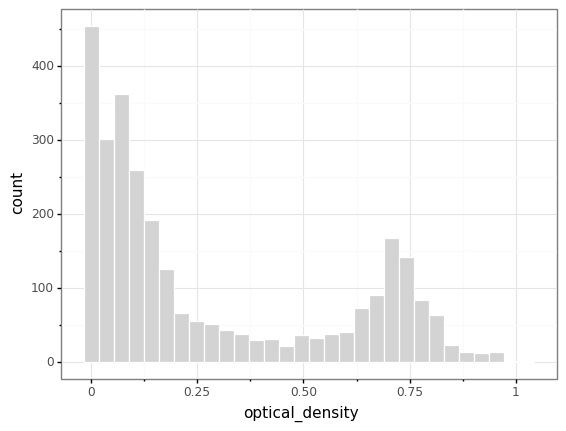

<ggplot: (8758308780133)>

In [44]:
(p9.ggplot(tidy_experiment, p9.aes(x='optical_density'))
    + p9.geom_histogram(bins=30, color='white', fill='lightgrey')
    + p9.theme_bw()
)

<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>Use a `violin plot` to check the distribution of the `optical_density` in each of the experiment time phases (`experiment_time_h`)</li>

</ul>

_Tip_: within plotnine, searching for a specific geometry always starts with typing `geom_` + TAB-button
</div>

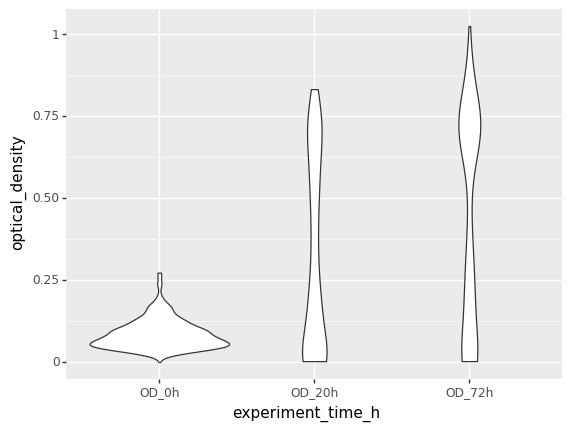

<ggplot: (8758308572041)>

In [45]:
(p9.ggplot(tidy_experiment, p9.aes(x='experiment_time_h', 
                                   y='optical_density'))
    + p9.geom_violin()
)

<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>For each `Phage_t` in an individual subplot, use a `violin plot` to check the distribution of the `optical_density` in each of the experiment time phases (`experiment_time_h`)</li>
</ul>

_Tip_: remember `facet_wrap`?

</div>



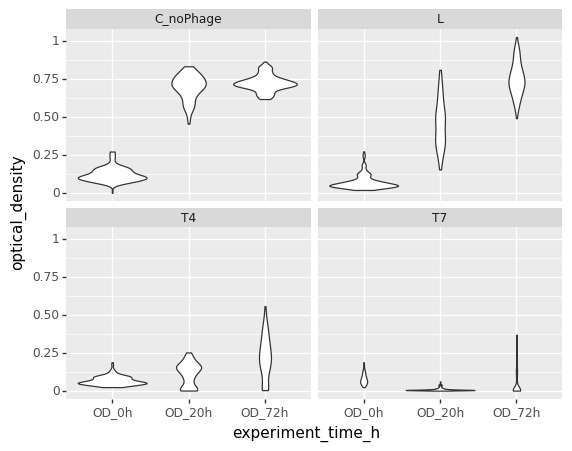

<ggplot: (8758311108053)>

In [46]:
(p9.ggplot(tidy_experiment, p9.aes(x='experiment_time_h', 
                                   y='optical_density'))
    + p9.geom_violin()
    + p9.facet_wrap('Phage_t')
)

<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>Create a summary table of the average `optical_density` with the `Bacterial_genotype` in the rows and the `experiment_time_h` in the columns</li>
</ul>

_Tip_: no plotnine required here

</div>

In [47]:
pd.pivot_table(tidy_experiment, values='optical_density', 
               index='Bacterial_genotype', 
               columns='experiment_time_h',
               aggfunc='mean')

experiment_time_h,OD_0h,OD_20h,OD_72h
Bacterial_genotype,,,
D516G,0.081090,0.308745,0.422481
D87G,0.094826,0.358149,0.435589
K43N,0.073319,0.229284,0.360857
K88R,0.087895,0.349078,0.441870
MUT,0.086279,0.370074,0.549770
RP4,0.100410,0.294452,0.438770
RSF1010,0.086731,0.338346,0.464583
S512F,0.059865,0.269255,0.413397
S83L,0.099519,0.352234,0.438004


In [48]:
tidy_experiment.groupby(['Bacterial_genotype', 'experiment_time_h'])['optical_density'].mean().unstack()

experiment_time_h,OD_0h,OD_20h,OD_72h
Bacterial_genotype,,,
D516G,0.081090,0.308745,0.422481
D87G,0.094826,0.358149,0.435589
K43N,0.073319,0.229284,0.360857
K88R,0.087895,0.349078,0.441870
MUT,0.086279,0.370074,0.549770
RP4,0.100410,0.294452,0.438770
RSF1010,0.086731,0.338346,0.464583
S512F,0.059865,0.269255,0.413397
S83L,0.099519,0.352234,0.438004


<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>Calculate for each combination of `Bacterial_genotype`, `Phage_t` and `experiment_time_h` the <i>mean</i> `optical_density` and store the result as a dataframe called `density_mean`</li>
  <li>Based on `density_mean`, make a <i>barplot</i> of the mean values for each `Bacterial_genotype`, with for each Bacterial_genotype an individual bar per `Phage_t` in a different color (grouped bar chart).</li>
  <li>Use the `experiment_time_h` to split into subplots. As we mainly want to compare the values within each subplot, make sure the scales in each of the subplots are adapted to the data range, and put the subplots on different rows.</li>
    <li>(OPTIONAL) change the color scale of the bars to a color scheme provided by <a href="http://colorbrewer2.org/#type=sequential&scheme=BuGn&n=3">colorbrewer</a></li>

</ul>
    
</div>



In [49]:
density_mean = (tidy_experiment
                .groupby(['Bacterial_genotype','Phage_t', 'experiment_time_h'])
                .mean().reset_index())

In [50]:
density_mean.head()

,Bacterial_genotype,Phage_t,experiment_time_h,Survival_72h,PhageR_72h,optical_density
0,D516G,C_noPhage,OD_0h,1.0,NaN,0.111187
1,D516G,C_noPhage,OD_20h,1.0,NaN,0.678304
2,D516G,C_noPhage,OD_72h,1.0,NaN,0.707550
3,D516G,L,OD_0h,1.0,1.0,0.068729
4,D516G,L,OD_20h,1.0,1.0,0.417167


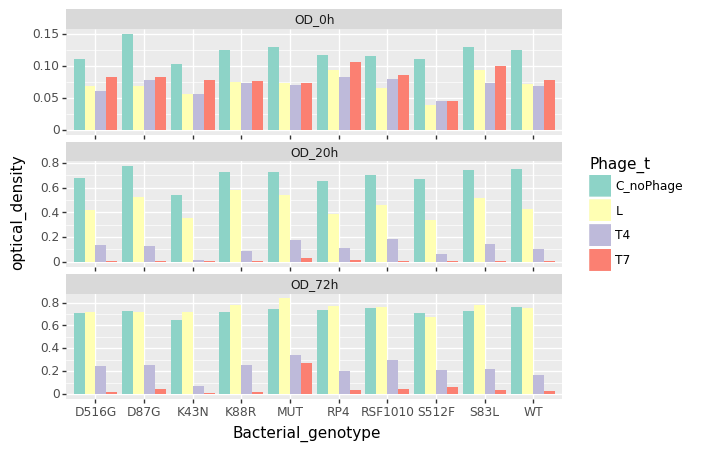

<ggplot: (8758309921305)>

In [51]:
(p9.ggplot(density_mean, p9.aes(x='Bacterial_genotype',
                                y='optical_density',
                                fill='Phage_t'))
    + p9.geom_bar(stat='identity', position='dodge')
    + p9.facet_wrap('experiment_time_h', scales='free', nrow=3)
    + p9.scale_fill_brewer(type='qual', palette=8)
)

## Reproduce the graphs of the original paper

<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>Check Figure 2 of the original journal paper in the 'correction' part of the <a href="http://rsbl.royalsocietypublishing.org/content/roybiolett/12/5/20160064.full.pdf">pdf</a>:</li>
     <img src="https://royalsocietypublishing.org/cms/attachment/eb511c57-4167-4575-b8b3-93fbcf728572/rsbl20160064f02.jpg" width="500">
  <li>Reproduce the graph using the `falcor` data and the plotnine package (don't bother yet about the style or the order on the x axis). The 'log10 mutation rate' on the figure corresponds to the `log10 Mc` column.</li>
    <li>Check the <a href="http://plotnine.readthedocs.io/en/stable/generated/plotnine.geoms.geom_errorbar.html#plotnine.geoms.geom_errorbar">documentation</a> to find out how to add errorbars to the graph. The upper and lower bound for the error bars are given in the `log10 UBc` and `log10 LBc` columns.</li>
  <li>Make sure the `WT(2)` and `MUT(2)` are used as respectively `WT` and `MUT`.</li>
</ul>
</div>


In [52]:
falcor["Bacterial_genotype"] = falcor["Bacterial_genotype"].replace({'WT(2)': 'WT', 
                                                                     'MUT(2)': 'MUT'})

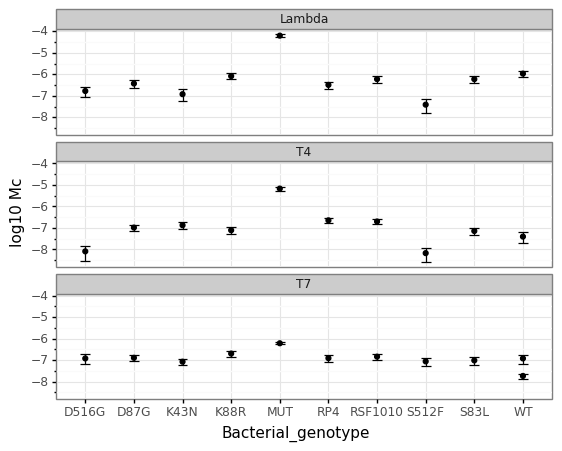

<ggplot: (8758309881029)>

In [53]:
(p9.ggplot(falcor, p9.aes(x='Bacterial_genotype', y='log10 Mc'))
    + p9.geom_point()
    + p9.facet_wrap('Phage', nrow=3)
    + p9.geom_errorbar(p9.aes(ymin='log10 LBc', ymax='log10 UBc'), width=.2)
    + p9.theme_bw()
)

<div class="alert alert-success">

<b>EXERCISE (OPTIONAL)</b>:

 <ul>
  <li>Check Figure 1 of the original <a href="http://rsbl.royalsocietypublishing.org/content/12/5/20160064#F1">journal paper</a>: <img src="https://royalsocietypublishing.org/cms/attachment/34f9e36c-04a8-4a33-b59c-d5a566a4a159/rsbl20160064f01.jpg" width="500"> </li>
  <li>Reproduce the graph using the `tidy_experiment` data and the plotnine package. Notice that the plot shows the optical density at the end of the experiment (72h).</li>
  <li>Take the `geom_` that closest represents the original.</li>
    <li>Check the <a href="http://plotnine.readthedocs.io/en/stable/api.html">documentation</a> for further tuning, e.g. <a href="http://plotnine.readthedocs.io/en/stable/generated/plotnine.facets.labelling.as_labeller.html#plotnine.facets.labelling.as_labeller">`as_labeller`</a>...</li>
</ul>
</div>



In [54]:
end_of_experiment = tidy_experiment[tidy_experiment["experiment_time_h"] == "OD_72h"].copy()

In [55]:
# The Nan-values of the PhageR_72h when no phage represent survival (1)
end_of_experiment["PhageR_72h"] = end_of_experiment["PhageR_72h"].fillna(0.)

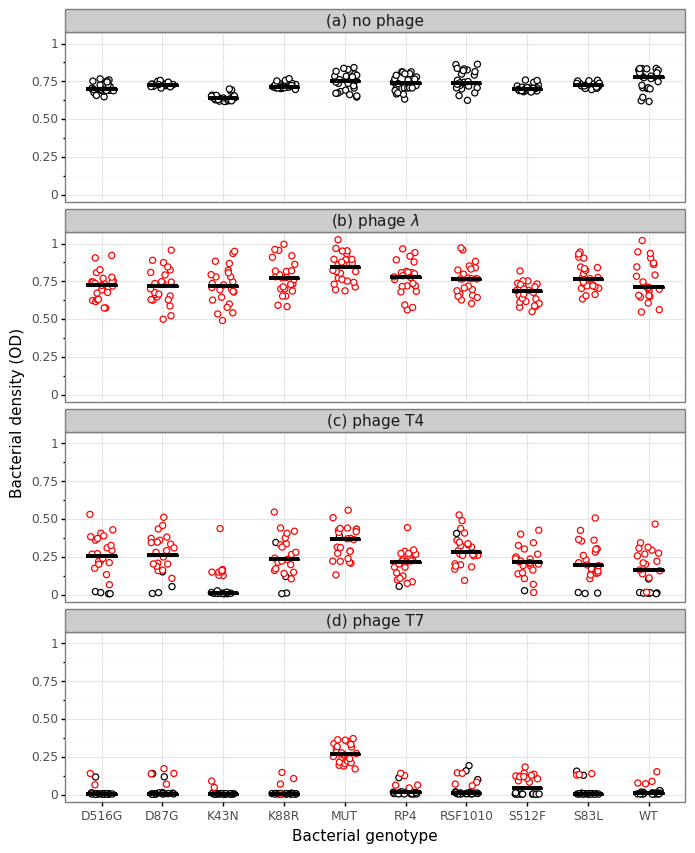

<ggplot: (8758311141145)>

In [56]:
# precalculate the median value
end_of_experiment["Phage_median"] = end_of_experiment.groupby(["Phage_t", "Bacterial_genotype"])['optical_density'].transform('median')

p9.options.figure_size = (8, 10)
(p9.ggplot(end_of_experiment, p9.aes(x='Bacterial_genotype', 
                                     y='optical_density'))
    + p9.geom_jitter(mapping=p9.aes(color='factor(PhageR_72h)'), 
                     width=0.2, height=0., size=2, fill='white')
    + p9.facet_wrap("Phage_t", nrow=4, 
                    labeller=p9.as_labeller({'C_noPhage' : '(a) no phage', 'L' : '(b) phage $\lambda$', 
                                             'T4' : '(c) phage T4', 'T7': '(d) phage T7'}))
    + p9.theme_bw()
    + p9.xlab("Bacterial genotype")
    + p9.ylab("Bacterial density (OD)")
    + p9.theme(strip_text=p9.element_text(size=11))
    + p9.geom_crossbar(inherit_aes=False, alpha=0.5,
                       mapping=p9.aes(x='Bacterial_genotype', y='Phage_median',
                                      ymin='Phage_median', ymax='Phage_median'))
    + p9.scale_color_manual(values=["black", "red"], guide=False)
)